## Encoding Rewards

#### Encoding Rewards

- We've now discussed the importance of encoding the observations.
- We may also have some choice on the action space, though here (and often) it is relatively clear/fixed.
- But what about the rewards? 

#### Current set-up

- Currently, we get a reward of +1 for reaching the goal. 
- This is part of what makes RL so hard (and impressive):
  - We want to learn about actions even though we don't know right away whether the action was "good". 
  - Contrast this with supervised learning, where every prediction we make on the training data can immediately be compared with the known target value.


In [1]:
# TODO: perhaps this next slide can be moved to Module 1, since it's very general?

#### Agents can't just be greedy

- Can agents simply learn to go for the best immediate reward?
- No. For example, in a video recommendation system, showing the user another funny cat video might make them click (high immediate reward) but result in long-term loss of interest in the service (low long-term reward).
- Our Frozen Lake is another example of the problem here: sometimes there is no immediate reward at all to learn from.

In [2]:
# TODO: perhaps this next section on "Learned action probabilities" could be moved much earlier, even as early as Module 1

#### Learned action probabilities

- RLlib lets us look inside the model at the probability of each action given an observation (i.e., the learned policy).
- Let's load the trained model with our encoded observations:

In [3]:
from envs import RandomLakeObs
from ray.rllib.agents.ppo import PPOTrainer

trainer_RandomLakeObs = PPOTrainer({"framework" : "torch", "create_env_on_driver" : True, "seed" : 0}, 
                       env=RandomLakeObs)

In [4]:
trainer_RandomLakeObs.restore("models/RandomLakeObs/checkpoint-8")

2022-05-31 11:52:49,922	INFO trainable.py:495 -- Restored on 127.0.0.1 from checkpoint: models/RandomLakeObs/checkpoint-8
2022-05-31 11:52:49,926	INFO trainable.py:503 -- Current state after restoring: {'_iteration': 8, '_timesteps_total': 32000, '_time_total': 26.671697854995728, '_episodes_total': 3536}


#### Learned action probabilities

The exact RLlib code is hidden inside `utils` for now, but we're mainly interested in the results:

In [5]:
from utils import query_policy
query_policy(trainer_RandomLakeObs, RandomLakeObs(), [0,0,0,0])

array([0.04938994, 0.5083452 , 0.4160391 , 0.02622576], dtype=float32)

- Recall the (left, down, right, up) ordering.
- When the observation is `[0 0 0 0]` (no holes or edges in sight), the agent prefers to go down and right.

What if there's a hole below you? We can feed in a different observation to the policy:

In [6]:
query_policy(trainer_RandomLakeObs, RandomLakeObs(), [0,1,0,0])

array([0.03247996, 0.02870463, 0.9153594 , 0.02345585], dtype=float32)

- Now the agent is very unlikely to go down, and very likely to go right!
- Again, all this was learned from trial and error, with a reward earned only when the goal was reached.

#### Random Lake rewards

- In the Random Lake example, can't be make life easier for the agent by giving immediate rewards?

This is the current reward code:

In [7]:
def reward(self):
    return int(self.player == self.goal)

- The agent has to learn, through trial and error over _entire episodes_, that moving down and right is generally a good thing. 

#### Redefining rewards

- Let's instead try giving a reward _at every step, that is higher as the agent gets closer to the goal_. 

In [8]:
from envs import RandomLakeObs

class RandomLakeObsRew(RandomLakeObs):
    def reward(self):
        return 6-(abs(self.player[0]-self.goal[0]) + abs(self.player[1]-self.goal[1]))

- The above method uses the [Manhattan Distance](https://en.wikipedia.org/wiki/Taxicab_geometry) between the player and the goal as the reward. 
- When the agent reaches the goal, the maximum reward of 6 is achieved.
- When the agent is furthest from the goal, the minimum reward of 0 is given.

#### Redefining rewards

In [9]:
env = RandomLakeObsRew()
env.reset()
env.render()
env.reward()

P...
....
O.O.
...G


0

Above, the reward is 0. Below, the reward is 1 because we moved closer to the goal.

In [10]:
obs, rew, done, _ = env.step(1)
env.render()
rew

....
P...
O.O.
...G


1

#### Redefining rewards

In [11]:
obs, rew, done, _ = env.step(2)
obs, rew, done, _ = env.step(2)
obs, rew, done, _ = env.step(2)
obs, rew, done, _ = env.step(1)
env.render()
rew

....
....
O.OP
...G


5

Now, the reward is 5. Next, it will be 6.

In [12]:
obs, rew, done, _ = env.step(1)
env.render()
rew

....
....
O.O.
...P


6

#### Comparing rewards

- So, we have two possible reward functions. Which one works better? 
- Recall that last time, after training for 8 iterations, we were able to reach the goal around 70% of the time:

In [14]:
trainer_RandomLakeObs.evaluate()['evaluation']['episode_reward_mean']

0.7023809523809523


#### Comparing rewards

Let's train with the new reward function!

In [15]:
trainer_RandomLakeObsRew = PPOTrainer({"framework" : "torch", "create_env_on_driver" : True, "seed" : 0}, 
                                      env=RandomLakeObsRew)

In [16]:
for i in range(8):
    trainer_RandomLakeObsRew.train()

In [17]:
trainer_RandomLakeObsRew.evaluate()['evaluation']['episode_reward_mean']

182.8181818181818


Wait a minute, what's going on here??

#### Comparing rewards?

- We tried to improve our RL system by shaping the reward function.
- This (presumably) affected training, but it also affected our evaluation.
- In supervised learning, this is like changed the scoring metric from squared error to absolute error.
- If the old system got a mean squared error of 20,000 and the new system got a mean absolute error of 40, which is better?
- We're comparing apples and oranges here!
- We want to compare both models on the same metric, for example the original metric. 
- Here, we want to see how frequently the agent reaches the goal.

In [18]:
# HIDDEN
from ray.rllib.agents.callbacks import DefaultCallbacks

class MyCallbacks(DefaultCallbacks):
    def on_episode_end(self, *, worker, base_env, policies, episode, env_index, **kwargs):
        info = episode.last_info_for()
        episode.custom_metrics["goal_reached"] = info["player"] == info["goal"]

In [31]:
trainer_RandomLakeObsRew = PPOTrainer({"framework" : "torch", "create_env_on_driver" : True, "seed" : 0, 
                                      "callbacks" : MyCallbacks},
                                      env=RandomLakeObsRew)

In [20]:
# outs = []
# for i in range(3):
#     outs.append(trainer.train())

In [21]:
trainer.evaluate()["evaluation"]["episode_reward_mean"]

58.05952380952381

In [22]:
trainer.evaluate()["evaluation"]["custom_metrics"]["goal_reached_mean"]

0.15625

In [32]:
trainer_RandomLakeObs = PPOTrainer({"framework" : "torch", "create_env_on_driver" : True, "seed" : 0,
                                   "callbacks" : MyCallbacks}, 
                                    env=RandomLakeObs)

In [33]:
RandomLakeObs_results = []
RandomLakeObsRew_results = []

for i in range(8):
    RandomLakeObs_results.append(trainer_RandomLakeObs.train())
for i in range(8):
    RandomLakeObsRew_results.append(trainer_RandomLakeObsRew.train())

(scheduler +4m54s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.
(scheduler +4m54s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


2022-05-31 11:57:48,215	WARNING worker.py:1326 -- The actor or task with ID ffffffffffffffffbab4b9802e47a5156bcc9d9301000000 cannot be scheduled right now. You can ignore this message if this Ray cluster is expected to auto-scale or if you specified a runtime_env for this actor or task, which may take time to install.  Otherwise, this is likely due to all cluster resources being claimed by actors. To resolve the issue, consider creating fewer actors or increasing the resources available to this Ray cluster.
Required resources for this actor or task: {CPU: 1.000000}
Available resources on this node: {0.000000/8.000000 CPU, 2.988483 GiB/2.988483 GiB memory, 1.494241 GiB/1.494241 GiB object_store_memory, 1.000000/1.000000 node:127.0.0.1}
 In total there are 0 pending tasks and 2 pending actors on this node.


In [34]:
import matplotlib.pyplot as plt

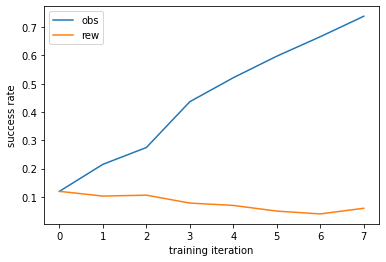

In [35]:
plt.plot([x["custom_metrics"]["goal_reached_mean"] for x in RandomLakeObs_results], label="obs")
plt.plot([x["custom_metrics"]["goal_reached_mean"] for x in RandomLakeObsRew_results], label="rew")
plt.xlabel("training iteration")
plt.ylabel("success rate")
plt.legend();

In [1]:
from envs import RandomLakeObsRew, RandomLakeObs, RandomLakeObsTest
import matplotlib.pyplot as plt

In [2]:
from ray.rllib.agents.callbacks import DefaultCallbacks

class MyCallbacks(DefaultCallbacks):
    def on_episode_end(self, *, worker, base_env, policies, episode, env_index, **kwargs):
        info = episode.last_info_for()
        episode.custom_metrics["goal_reached"] = info["player"] == info["goal"]

In [3]:
from ray.rllib.agents.ppo import PPOTrainer

trainer_RandomLakeObsRew = PPOTrainer({"framework" : "torch", "create_env_on_driver" : True, "seed" : 0, 
                                      "callbacks" : MyCallbacks},
                                      env=RandomLakeObsRew)

trainer_RandomLakeObs = PPOTrainer({"framework" : "torch", "create_env_on_driver" : True, "seed" : 0,
                                   "callbacks" : MyCallbacks}, 
                                    env=RandomLakeObs)

trainer_RandomLakeObsTest = PPOTrainer({"framework" : "torch", "create_env_on_driver" : True, "seed" : 0,
                                   "callbacks" : MyCallbacks}, 
                                    env=RandomLakeObsTest)

In [4]:
# for i in range(8):
#     trainer_RandomLakeObsRew.train()

In [7]:
outs_RandomLakeObs = []
for i in range(8):
    outs_RandomLakeObs.append(trainer_RandomLakeObs.train())

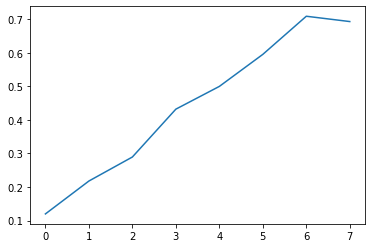

In [8]:
plt.plot([x["custom_metrics"]["goal_reached_mean"] for x in outs_RandomLakeObs]);

In [6]:
trainer_RandomLakeObs.evaluate()["evaluation"]["custom_metrics"]["goal_reached_mean"]

0.7383720930232558

In [4]:
outs_RandomLakeObsTest = []
for i in range(8):
    outs_RandomLakeObsTest.append(trainer_RandomLakeObsTest.train())

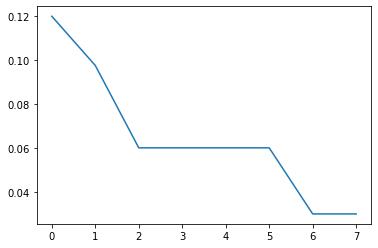

In [5]:
plt.plot([x["custom_metrics"]["goal_reached_mean"] for x in outs_RandomLakeObsTest]);

In [6]:
trainer_RandomLakeObsTest.evaluate()["evaluation"]["custom_metrics"]["goal_reached_mean"]

0.0

OBSERVATION:

- if you -0.1 from all rewards, it works OK, if you +0.1 to all rewards, it fails horribly.

In [10]:
trainer_RandomLakeObs.config["model"]["vf_share_layers"]

False

In [30]:
env = RandomLakeObsTest()
obs = env.reset()

In [45]:
action = trainer_RandomLakeObsTest.compute_single_action(input_dict={"obs": obs})#, explore=False)
res = env.step(action)
obs = res[0]
env.render()

print("\naction:", action)
print("reward:", res[1])
print("done:", res[2])
print("obs:", obs)

.P.O
O...
....
...G

action: 2
reward: 0.1
done: False
obs: [0 0 0 1]


# NEXT TODO

figure out why the agent with the shaped reward isn't working at all

- make sure it's actually bad (and not a metrics issue) by rendering - YES
- does the absolute reward matter, e.g. if i subtract 6 from all the rewards what happens - SVEN SAYS NO BUT CHECK
- is the problem that it's better to just go back and forth safely and not even try for the goal?
- note: this reward shaping may help more for a bigger maze when it takes more actions to get feedback

#### callback thing

#### training curves

#### disadvantages - loss of generality

- now only works if goal is at bottom-right
give a few real-world examples here -> important